<a href="https://colab.research.google.com/github/fmurital/Natural-Gas-Storage-Contract-Pricing-Model/blob/main/Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

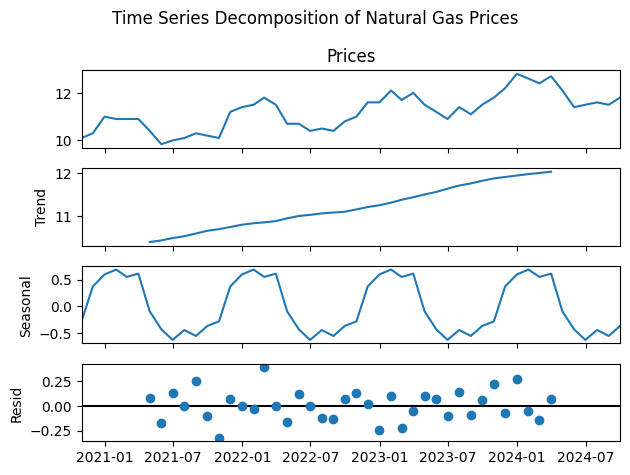

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime

# Load the data with explicit date format
data = pd.read_csv('Nat_Gas.csv')
data['Dates'] = pd.to_datetime(data['Dates'], format='%m/%d/%y')  # Specify the date format
data.set_index('Dates', inplace=True)
data['Prices'] = data['Prices'].astype(float)

# Set frequency explicitly for time series analysis
data = data.asfreq('ME')  # Month End frequency (replaces deprecated 'M')

# Function to estimate price at any given date
def estimate_price(input_date):
    try:
        # Convert input to datetime if it's a string
        if isinstance(input_date, str):
            input_date = pd.to_datetime(input_date)

        # Check if date is in historical data
        if input_date in data.index:
            return float(data.loc[input_date, 'Prices'])

        # For dates between known data points, use linear interpolation
        elif input_date < data.index[-1]:
            # Find surrounding dates
            before = data[data.index <= input_date].index[-1]
            after = data[data.index >= input_date].index[0]

            # Calculate days between
            days_between = (after - before).days
            days_to_input = (input_date - before).days

            # Linear interpolation
            price_before = data.loc[before, 'Prices']
            price_after = data.loc[after, 'Prices']
            interpolated_price = price_before + (price_after - price_before) * (days_to_input / days_between)
            return float(interpolated_price)

        # For future dates (forecasting)
        else:
            days_ahead = (input_date - data.index[-1]).days
            if days_ahead > 365:  # Limit to 1 year forecast
                raise ValueError("Date is more than 1 year beyond available data")
            return float(forecasted_prices.loc[input_date.strftime('%Y-%m'), 'Prices'])

    except Exception as e:
        print(f"Error processing date {input_date}: {str(e)}")
        return None

# Time series decomposition to understand patterns
decomposition = seasonal_decompose(data['Prices'], model='additive', period=12)
decomposition.plot()
plt.suptitle('Time Series Decomposition of Natural Gas Prices')
plt.tight_layout()
plt.show()

# Holt-Winters forecasting model
model = ExponentialSmoothing(data['Prices'],
                            trend='add',
                            seasonal='add',
                            seasonal_periods=12,
                            damped_trend=True)
model_fit = model.fit()

In [ ]:
# Forecast for 12 months into the future
forecast = model_fit.forecast(12)
forecast_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=12, freq='ME')  # Using 'ME' instead of 'M'
forecasted_prices = pd.DataFrame(forecast.values, index=forecast_dates, columns=['Prices'])

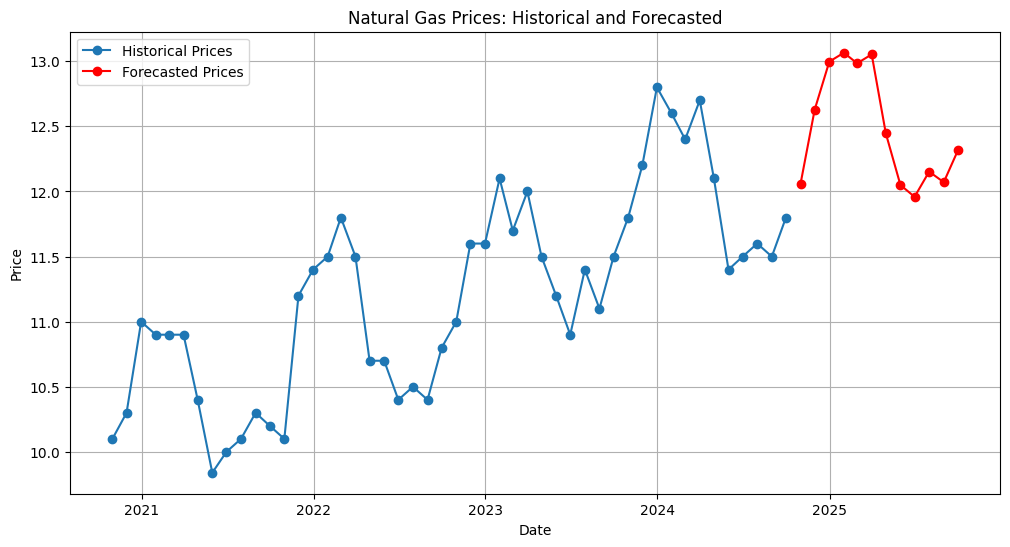


Price Estimates:
2023-12-15: $12.49
2024-06-15: $11.45
2025-03-15: $13.05
2025-09-30: $12.31


/tmp/ipython-input-3-2975529524.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(forecasted_prices.loc[input_date.strftime('%Y-%m'), 'Prices'])


In [ ]:
# Plot historical and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Prices'], label='Historical Prices', marker='o')
plt.plot(forecasted_prices.index, forecasted_prices['Prices'], label='Forecasted Prices', color='red', marker='o')
plt.title('Natural Gas Prices: Historical and Forecasted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Example usage with error handling
test_dates = ['2023-12-15', '2024-06-15', '2025-03-15', '2025-09-30']
print("\nPrice Estimates:")
for date in test_dates:
    price = estimate_price(date)
    if price is not None:
        print(f"{date}: ${price:.2f}")
    else:
        print(f"{date}: Could not estimate price")